# LSTM: detecting emotion in text

Author: Hugo Wattelar

Natural Language Processing (NLP) is now a major field of AI research: machine translation, text understanding, chatbots, etc. Text, speech or video are data sequences that have a dependency (temporal or contextual) that cannot be captured correctly by feed-forward networks. Text, speech or video are data sequences that have a dependency (temporal or contextual) that cannot be captured correctly by feed-forward networks. Recurrent networks (RNN) are better suited to this type of data. In particular, LSTM (Long Short Term Memory) networks are specialised in analysing data sequences thanks to their ability to 'remember'.

In this tutorial, we are going to use an LSTM-based neural network to detect emotions in a text. This apparently easy task is, however, highly open to interpretation, and the emotion conveyed in a text can be anything and everything depending on the context, intention or other subjective components.

To do this, we're going to use the PyTorch library, which is particularly useful for implementing neural networks in Python. This library is not installed by default on Jupyter, so you need to download it using the following command (this can take several minutes, so please be patient). Installation is complete when the star [*] to the left of the cell disappears. As long as the star appears, the installation is not complete.

In [5]:
pip install torch

First, let's install all the libraries we'll need for this tutorial. Run the cell below and check that everything has been imported correctly.

In [6]:
import pandas as pd
import numpy as np
import re
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam

## 1. data loading and exploration

For this study, we will use the [Emotion Dataset](https://github.com/dair-ai/emotion_dataset?tab=readme-ov-file) described in _Elvis Saravia, Hsien-Chi Toby Liu, Yen-Hao Huang, Junlin Wu, and Yi-Shin Chen. 2018. CARER: Contextualized Affect Representations for Emotion Recognition. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing, pages 3687-3697, Brussels, Belgium. Association for Computational Linguistics._ It consists of several thousand English tweets annotated with 6 different emotions:
* 0 : _sadness_
* 1: _joy_
* 2: _love_
* 3: _angry_
* 4: _fear_
* 5: _surprise_

The base is already separated into a training base, a validation base and a test base. We load the 3 sets into 3 different variables.

In [7]:
train_set = pd.read_csv("Emotion_Dataset/training.csv")
val_set = pd.read_csv("Emotion_Dataset/validation.csv")
test_set = pd.read_csv("Emotion_Dataset/test.csv")
emotions = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}

In [8]:
print("train_set :", train_set.shape)
print("val_set :", val_set.shape)
print("test_set :", test_set.shape)

train_set : (16000, 2)
val_set : (2000, 2)
test_set : (2000, 2)


A few examples of the database are displayed.

In [9]:
print(train_set.head(10))

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3
5  ive been feeling a little burdened lately wasn...      0
6  ive been taking or milligrams or times recomme...      5
7  i feel as confused about life as a teenager or...      4
8  i have been with petronas for years i feel tha...      1
9                                i feel romantic too      2


We now display a few examples of the database for each emotion.

In [10]:
for i in range(0,6):
    print("Emotion :", emotions[i])
    print(train_set.loc[train_set.label==i].head(10))
    print("\n")

Emotion : sadness
                                                 text  label
0                             i didnt feel humiliated      0
1   i can go from feeling so hopeless to so damned...      0
5   ive been feeling a little burdened lately wasn...      0
10  i feel like i have to make the suffering i m s...      0
13                 i feel low energy i m just thirsty      0
16               i didnt really feel that embarrassed      0
17            i feel pretty pathetic most of the time      0
18  i started feeling sentimental about dolls i ha...      0
25  i still love my so and wish the best for him i...      0
26  i feel so inhibited in someone elses kitchen l...      0


Emotion : joy
                                                 text  label
8   i have been with petronas for years i feel tha...      1
11  i do feel that running is a divine experience ...      1
14  i have immense sympathy with the general point...      1
15    i do not feel reassured anxiety is on each si

The distribution of the different emotions in the three databases is shown below.

<span style="color: red"> Question:</span> what do you think about that?

<span style="color: blue"> Answer:</span> the different emotions are correctly distributed between the different sets. This is important to ensure that all emotions are represented in all three bases. However, the emotions "joy" and "sadness" are much more present than the others, which could bias the final model in favour of these emotions.

Text(0.5, 1.0, 'Test set')

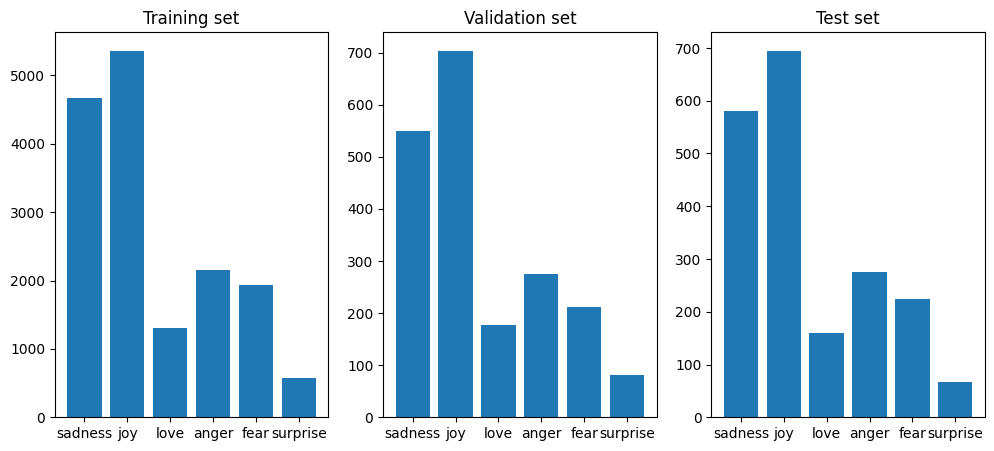

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
ax[0].bar(emotions.values(), train_set.groupby("label").size())
ax[0].set_title("Training set")
ax[1].bar(emotions.values(), val_set.groupby("label").size())
ax[1].set_title("Validation set")
ax[2].bar(emotions.values(), test_set.groupby("label").size())
ax[2].set_title("Test set")

## 2. Data processing

### 2.1 Tokenisation

The textual data must first be processed in order to format it for the AI model. Special characters and punctuation are removed from the data, and sentences are separated into words, called _tokens_. This process is called _tokenisation_.

In [12]:
def tokenize_text(text):
    """Tokenization of a sentence"""
    text = text.lower() # Everything in lower case
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Punctuation and special characters are removed
    tokens = text.split() # Sentences are divided into word lists
    return tokens

def tokenize_dataset(dataset):
    """Tokenization of a whole dataset"""
    processed_set = []
    for index, sample in dataset.iterrows():
        text = sample["text"]
        tokens = tokenize_text(text) # Tokenisation of each sentence
        processed_set.append(tokens)
    labels = dataset.label # The labels associated with each sentence are stored in memory
    return processed_set, labels

In [13]:
sentences_train, y_train = tokenize_dataset(train_set)
sentences_val, y_val = tokenize_dataset(val_set)
sentences_test, y_test = tokenize_dataset(test_set)

### 2.2 Encoding

Next, we encode our tokens to form a dictionary. This involves associating an ID with each word, to convert each word into an integer specific to each word.
The more words are encoded, the larger the vocabulary of the model. A word that does not exist in the dictionary cannot be processed by the model.
Here, we encode the words in the 3 databases to ensure that each word used has an associated ID.

In [14]:
encoder = LabelEncoder() # Installing the encoder

sentences = []
for sentence in sentences_train + sentences_val + sentences_test: # Concatenation of words from the 3 databases
    sentences += sentence

tokens_ids = encoder.fit_transform(sentences) # Learning the encoder with all the words

View the token dictionary and the number of occurrences of each word:

In [15]:
dictionnary = pd.DataFrame(data={"word": sentences, "token_id": tokens_ids})
dictionnary.drop_duplicates(inplace=True)
dictionnary["nb_occurences"] = [sentences.count(i) for i in dictionnary["word"]]
print(dictionnary.head(10))

          word  token_id  nb_occurences
0            i      7306          32242
1        didnt      4089            334
2         feel      5539          13938
3   humiliated      7240             67
5          can      2128           1200
6           go      6377            493
7         from      6045            876
8      feeling      5543           6431
9           so     13866           3127
10    hopeless      7131             76


<span style="color: red"> TODO:</span> display words matching the first token_ids. How are the token_ids chosen?

In [16]:
sort_id_dictionnary = dictionnary.sort_values(by="token_id")
print(sort_id_dictionnary.head(10))

             word  token_id  nb_occurences
27              a         0           7748
125288         aa         1              3
175746  aaaaaaand         2              1
93666     aaaaand         3              1
350153      aaaah         4              1
271339     aaaand         5              1
8161          aac         6              1
11710       aahhh         7              1
133082      aaron         8              1
57414          ab         9              1


<span style="color: red"> TODO:</span> display the most frequent words in the database.

In [17]:
sort_occ_dictionnary = dictionnary.sort_values(by="nb_occurences", ascending=False)
print(sort_occ_dictionnary.head(10))

        word  token_id  nb_occurences
0          i      7306          32242
2       feel      5539          13938
22       and       554          11996
11        to     15334          11208
41       the     15123          10462
27         a         0           7748
8    feeling      5543           6431
46      that     15116           6314
164       of     10366           6182
321       my      9882           5326


<span style="color: red"> TODO:</span> how many different words are there in the database?

In [18]:
dictionnary.shape
print("Number of different words=", dictionnary.shape[0])

Number of different words= 17096


Finally, the 3 databases are encoded separately.

In [19]:
def encode_sentences(encoder, sentences):
    """Associates the corresponding ID to each word in sentences"""
    encoded_sentences = []
    for sentence in sentences:
        encoded_sentence = encoder.transform(sentence)
        encoded_sentences.append(encoded_sentence)
    return encoded_sentences

In [20]:
# Encoding of the 3 databases (this may take a little time)
X_train = encode_sentences(encoder, sentences_train)
X_val = encode_sentences(encoder, sentences_val)
X_test = encode_sentences(encoder, sentences_test)

### 2.3 Padding

Ideally, all the entries in the model should have the same size (the same length). Here we will pad out all the sentences with zeros until they are all the size of the longest sentence in the corpus.

<span style="color: red"> TODO:</span> complete the code below in order to perform the padding step.

In [21]:
def make_zero_padding(data, output_size):
    for i in range(len(data)):
        for j in range(output_size-len(data[i])):
            data[i] = np.append(data[i], 0)
    return data

length_longest_sentence = max(len(max(X_train, key=len)), len(max(X_val, key=len)), len(max(X_test, key=len)))
X_train = make_zero_padding(X_train, length_longest_sentence)
X_val = make_zero_padding(X_val, length_longest_sentence)
X_test = make_zero_padding(X_test, length_longest_sentence)

Now that all the sentences have the same length, we can convert the lists of sentences into np.array.

In [22]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(16000, 66) (16000,)
(2000, 66) (2000,)
(2000, 66) (2000,)


### 2.4 One-hot encoding

As we saw when we loaded the database, each sentence is assigned an ID from 0 to 5 depending on the emotion it conveys. In order to train our model, we need to transform each `i` ID into a vector of size 6, where the `i`th element is worth 1 and the other elements are worth 0. This is called one-hot encoding.

<span style="color: red"> TODO:</span> complete the code below to perform the one-hot encoding step.

In [23]:
y_train_one_hot = nn.functional.one_hot(torch.tensor(y_train))
y_val_one_hot = nn.functional.one_hot(torch.tensor(y_val))
y_test_one_hot = nn.functional.one_hot(torch.tensor(y_test))

### 2.5 Formatting for PyTorch

Using the tools in the PyTorch library requires special formatting of the data (in particular conversion to torch.Tensor), which is carried out by the cell below.

In [24]:
class TextDataset(Dataset):
    def __init__(self, X,y):
        self.data = X
        self.labels = y


    def __len__(self):
        return len(self.data)


    def __getitem__(self, index):
        sequence, label = self.data[index], self.labels[index]
        return torch.tensor(sequence, dtype=torch.long).clone().detach(), torch.tensor(label, dtype=torch.long).clone().detach()


# Preparing DataLoaders
train_dataset = TextDataset(X_train, y_train_one_hot)
val_dataset = TextDataset(X_val, y_val_one_hot)
test_dataset = TextDataset(X_test, y_test_one_hot)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, shuffle=True)
test_loader = DataLoader(test_dataset, shuffle=False)

Finally, we have three DataLoaders (train, val, test) containing the cut, encoded, padded and formatted sentences, as well as the corresponding encoded labels.

## 3. Creating the emotion detection model

We will now use PyTorch to design our recurrent neural network for detecting emotion in text.
The proposed architecture is adapted from the code in [Adem Hamici](https://www.kaggle.com/code/ademhph/emotion-recognition-using-lstm).

In [25]:
class LSTMModel(nn.Module):
    """LSTM model for emotion classification"""
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.bi_lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True, bidirectional=True)
        self.batchnorm = nn.BatchNorm1d(hidden_size*2)  #
        self.fc = nn.Linear(hidden_size*2, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X):

        X = self.embedding(X) # Words are projected into a space where words with the same meaning are close together.

        _, (hn, _) = self.bi_lstm(X) # The sentence is read and analysed in both directions

        X = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1) # Concatenate the final hidden states of the bidirectional LSTM

        X = self.batchnorm(X) # Batch standardisation to speed up training

        X = self.fc(X) # Merging information

        return self.softmax(X) # Application of the softmax function to transform output values into probabilities

In [26]:
vocab_size = len(encoder.classes_)
embedding_size = 100
hidden_size = 150
output_size = 6

model = LSTMModel(vocab_size, embedding_size, hidden_size, output_size)
print(model)

LSTMModel(
  (embedding): Embedding(17096, 100)
  (bi_lstm): LSTM(100, 150, batch_first=True, bidirectional=True)
  (batchnorm): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=300, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)


## 4. Training, evaluation and testing of the model

We will now create the training, evaluation and test functions for the model. The training function contains an Early Stopping system, which stops the model training when the loss on the validation set increases during `patience` consecutive periods.

<span style="color: red"> Question:</span> in your opinion, how useful is Early Stopping?

<span style="color: blue"> Answer:</span> Early Stopping is useful because it is used to prevent overfitting by halting the training process when the model's performance on a validation dataset stops improving.

In [27]:
# Training function with early stopping
def train(model, train_loader, val_loader, criterion, optimizer, epochs=5, patience=3):
    best_val_loss = float('inf')  # Initialisation of the best validation loss for a large number of users
    patience_count = 0  # Patience counter

    for epoch in range(epochs):
        # Training mode
        model.train()
        total_loss = 0

        for sequences, labels in train_loader:
            optimizer.zero_grad()
            output = model(sequences)
            loss = criterion(output, labels.to(torch.float))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}')

        # Assessment method for the validation set
        val_loss = evaluate(model, val_loader, criterion)

        print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

        # Verification of the improvement in validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss  # Update the best validation loss
            patience_count = 0  # Resetting the patience counter
            # You can save the model if you need to
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_count += 1
            if patience_count >= patience:
                print("Early stopping triggered")
                break

# Evaluation function to calculate the loss of validation
def evaluate(model, val_loader, criterion):
    model.eval()  # Evaluation mode (disables dropout, etc.)
    total_val_loss = 0

    with torch.no_grad():  # No need to calculate gradients
        for sequences, labels in val_loader:
            output = model(sequences)
            loss = criterion(output, labels.to(torch.float))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    return avg_val_loss

def test(model, test_loader):
    model.eval()
    total_correct = 0
    predictions = []
    with torch.no_grad():
        for sequences, labels in test_loader:
            output = model(sequences)
            prediction = torch.argmax(output, dim=1)
            labels = torch.argmax(labels)
            total_correct += (prediction == labels).sum().item()
            predictions.append(prediction)
    accuracy = total_correct / len(test_loader.dataset)
    print(f'Accuracy: {accuracy:.4f}')
    return torch.tensor(predictions)

### 4.1 Model training

We're (finally!) going to move on to training the model. We choose an optimizer and a criterion.

<span style="color: red"> TODO:</span> start the workout. What do you notice? How do you explain it?

In [28]:
optimizer = Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs=5
patience=3

In [29]:
# train(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=3)

### 4.2 Loading the best model

The best model, saved during training, is loaded.

In [42]:
model = LSTMModel(vocab_size, embedding_size, hidden_size, output_size)
model.load_state_dict(torch.load('saved_model.pth', weights_only=True))

<All keys matched successfully>

### 4.3 Evaluation of the model on a test basis

<span style="color: red"> Question:</span> Test the model on the test base. What do you think of it?

<span style="color: blue"> Answer:</span> With an accuracy of around 0.9 (90%), the model is pretty good. But it's not amazing, maybe because of the bias created by the over-representation of "joy" and "sadness" in the training and validation datasets.

In [43]:
predictions = test(model, test_loader)

/tmp/ipython-input-24-514565054.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sequence, dtype=torch.long).clone().detach(), torch.tensor(label, dtype=torch.long).clone().detach()


Accuracy: 0.9025


<span style="color: red"> TODO:</span> Display the confusion matrix.

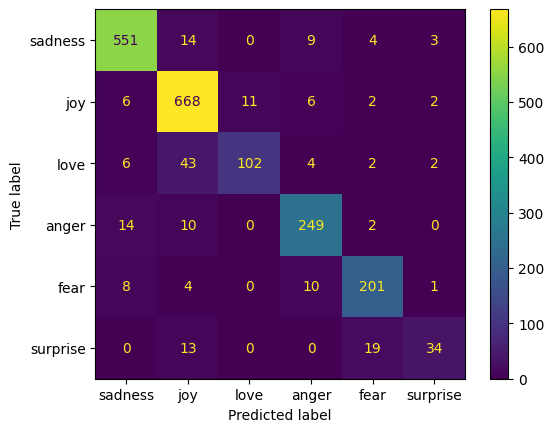

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=emotions.values())
disp.plot()

<span style="color: red"> TODO:</span> Display a few sentences from the test base whose prediction is wrong, with the actual emotion and the predicted emotion.

In [45]:
test_set["prediction"] = np.array(predictions)

test_set.loc[np.array(predictions)!=y_test]

,text,label,prediction
6,i felt anger when at the end of a telephone call,3,1
10,i don t feel particularly agitated,4,3
22,i survey my own posts over the last few years ...,1,5
26,i am feeling outraged it shows everywhere,3,1
34,i feel like i m defective or something for not...,0,5
...,...,...,...
1959,i check you when you re sleeping feel your nos...,1,2
1964,i was feeling disheartened when going on dates...,0,3
1970,i guess as long as the table in the above is p...,2,5
1979,i have no strong feelings for this book neithe...,3,0


## 5. Emotion prediction

<span style="color: red"> TODO:</span> Using everything we've done so far, build a function to predict the emotion of a given sentence using the model we've created and trained. Put it to the test!

In [46]:
def predict_emotion(model, encoder, sentence):
    print("Original sentence :", sentence)
    tokens = tokenize_text(sentence)
    print("Tokenized sentence :", tokens)
    encoded_sentence = encode_sentences(encoder, [tokens])
    print("Encoded sentence :", encoded_sentence)
    padded_sentence = make_zero_padding(encoded_sentence, length_longest_sentence)
    print("Padded encoded sentence :", padded_sentence)
    x = torch.tensor(np.array(padded_sentence))
    output = model(x)
    print("Predicted output :", output)
    emotion = emotions[np.argmax(output.detach().numpy())]
    print("Predicted emotion :", emotion)
    return

In [48]:
predict_emotion(model, encoder, "I am not happy")

Original sentence : I am not happy
Tokenized sentence : ['i', 'am', 'not', 'happy']
Encoded sentence : [array([ 7306,   483, 10205,  6728])]
Padded encoded sentence : [array([ 7306,   483, 10205,  6728,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])]
Predicted output : tensor([[6.1495e-19, 1.0000e+00, 7.5164e-17, 1.1425e-14, 7.5980e-16, 3.5612e-19]],
       grad_fn=<SoftmaxBackward0>)
Predicted emotion : joy


## Conclusion

<span style="color: red"> TODO:</span> Conclude on this study: what do you think? What are the strengths and weaknesses of this model? How could we improve it? What is the usefulness of such a system? Is it really useful? Is there a need for such a system? You can express your feelings, positive or negative.

It is really interesting to see how a text is processed by a LSTM. <br>
This model in particular is quite good to recognize the emotion in a text, even if it is way to much influenced by few words. For instance, if we say "I am not happy", the model will mostly focus on the world "happy" and so consider the emotion of this text as "joy".<br>
We can also notice that the emotion less represented in the datasets are often less predicted correctly than the joy or sadness, certainly due to the bias in the datasets.<br>
Such a system might be useful to detect the emotions during a conversation for example